In [2]:
from fastai.data.all import *

In [3]:
from fastai.vision.all import *

In [4]:
from rhana.labeler.unet import *

In [5]:
from skimage import io as skm_io

In [6]:
import numpy as np

# Fastai demo

In [85]:
path = untar_data(URLs.CAMVID_TINY)

In [6]:
!ls {path}

codes.txt  images  labels


In [7]:
!ls {path}/labels

0001TP_006750_P.png  0016E5_01500_P.png  0016E5_08550_P.png
0001TP_006840_P.png  0016E5_01920_P.png  Seq05VD_f00000_P.png
0001TP_007500_P.png  0016E5_02250_P.png  Seq05VD_f00090_P.png
0001TP_007860_P.png  0016E5_05190_P.png  Seq05VD_f00210_P.png
0001TP_008070_P.png  0016E5_05310_P.png  Seq05VD_f00420_P.png
0001TP_008160_P.png  0016E5_05730_P.png  Seq05VD_f00480_P.png
0001TP_008400_P.png  0016E5_05940_P.png  Seq05VD_f00810_P.png
0001TP_008580_P.png  0016E5_06090_P.png  Seq05VD_f00990_P.png
0001TP_008670_P.png  0016E5_06240_P.png  Seq05VD_f01080_P.png
0001TP_008700_P.png  0016E5_06300_P.png  Seq05VD_f01260_P.png
0001TP_008760_P.png  0016E5_06570_P.png  Seq05VD_f01320_P.png
0001TP_008940_P.png  0016E5_06810_P.png  Seq05VD_f01440_P.png
0001TP_009000_P.png  0016E5_06870_P.png  Seq05VD_f01830_P.png
0001TP_009150_P.png  0016E5_06990_P.png  Seq05VD_f01890_P.png
0001TP_009360_P.png  0016E5_07290_P.png  Seq05VD_f01950_P.png
0001TP_009840_P.png  0016E5_07973_P.png  Seq05VD_f02070_P.png
0001TP_009

In [86]:
fnames = get_image_files(path/'images')

In [87]:
def label_func(x): return path/'labels'/f'{x.stem}_P{x.suffix}'
codes = np.loadtxt(path/'codes.txt', dtype=str)
    
dls = SegmentationDataLoaders.from_label_func(path, fnames, label_func, codes=codes)

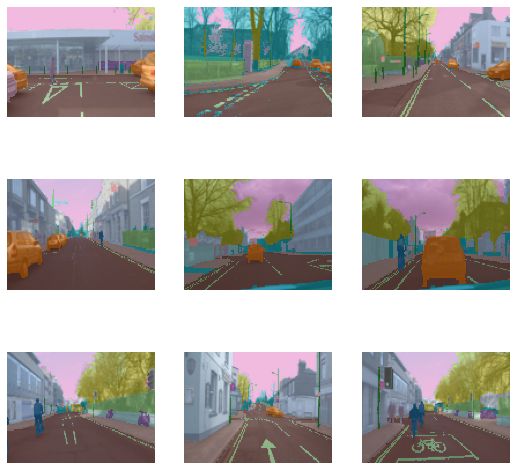

In [88]:
dls.show_batch()

In [11]:
np.loadtxt(path/'codes.txt', dtype=str)

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [89]:
camvid = DataBlock(blocks=(ImageBlock, MaskBlock(codes = np.loadtxt(path/'codes.txt', dtype=str))),
    get_items=get_image_files,
    splitter=RandomSplitter(),
    get_y=lambda o: path/'labels'/f'{o.stem}_P{o.suffix}',
    batch_tfms=aug_transforms())

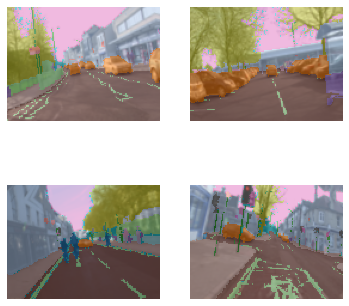

In [90]:
dls = camvid.dataloaders(path/"images", bs=4)
dls.show_batch()

In [102]:
x, y= dls.train.one_batch()

In [103]:
x = np.array(x.cpu())
y = np.array(y.cpu())

In [104]:
x.min(), x.max()

(0.006126296, 1.0)

In [105]:
unet_learner??

In [15]:
learn = unet_learner(dls, resnet18)

In [11]:
learn.fine_tune(1, )

epoch,train_loss,valid_loss,time
0,2.336553,2.306845,00:04


epoch,train_loss,valid_loss,time
0,1.535663,1.369838,00:02


In [ ]:
# Let make a datablock that read multi mask label
# the show result must also be done

In [ ]:
class TransformBlock():
    "A basic wrapper that links defaults transforms for the data block API"
    def __init__(self, type_tfms=None, item_tfms=None, batch_tfms=None, dl_type=None, dls_kwargs=None):
        self.type_tfms  =            L(type_tfms)
        self.item_tfms  = ToTensor + L(item_tfms)
        self.batch_tfms =            L(batch_tfms)
        self.dl_type,self.dls_kwargs = dl_type,({} if dls_kwargs is None else dls_kwargs)

In [ ]:
class PILBase(Image.Image, metaclass=BypassNewMeta):
    _bypass_type=Image.Image
    _show_args = {'cmap':'viridis'}
    _open_args = {'mode': 'RGB'}
    @classmethod
    def create(cls, fn:(Path,str,Tensor,ndarray,bytes), **kwargs)->None:
        "Open an `Image` from path `fn`"
        if isinstance(fn,TensorImage): fn = fn.permute(1,2,0).type(torch.uint8)
        if isinstance(fn, TensorMask): fn = fn.type(torch.uint8)
        if isinstance(fn,Tensor): fn = fn.numpy()
        if isinstance(fn,ndarray): return cls(Image.fromarray(fn))
        if isinstance(fn,bytes): fn = io.BytesIO(fn)
        return cls(load_image(fn, **merge(cls._open_args, kwargs)))

    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))

    def __repr__(self): return f'{self.__class__.__name__} mode={self.mode} size={"x".join([str(d) for d in self.size])}'

# Cell
class PILMask(PILBase): _open_args,_show_args = {'mode':'L'},{'alpha':0.5, 'cmap':'tab20'}

In [ ]:
class AddMaskCodes(Transform):
    "Add the code metadata to a `TensorMask`"
    def __init__(self, codes=None):
        self.codes = codes
        if codes is not None: self.vocab,self.c = codes,len(codes)

    def decodes(self, o:TensorMask):
        if self.codes is not None: o.codes=self.codes
        return o

In [ ]:
def MaskBlock(codes=None):
    "A `TransformBlock` for segmentation masks, potentially with `codes`"
    return TransformBlock(type_tfms=PILMask.create, item_tfms=AddMaskCodes(codes=codes), batch_tfms=IntToFloatTensor)

In [ ]:
# Cell
@delegates(plt.Axes.imshow, keep=True, but=['shape', 'imlim'])
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    # Handle pytorch axis order
    if hasattrs(im, ('data','cpu','permute')):
        im = im.data.cpu()
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]

    ax = ifnone(ax,ctx)
    if figsize is None: figsize = (_fig_bounds(im.shape[0]), _fig_bounds(im.shape[1]))
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax


In [ ]:
# from fastai core
def merge(*ds):
    "Merge all dictionaries in `ds`"
    return {k:v for d in ds if d is not None for k,v in d.items()}

# Load Data

In [6]:
!ls ../data/masking/

allitems.csv  IT006  IT011  IT016	peak_distances	   tracking_merge
export.pkl    IT007  IT012  IT017	peak_distances_v2  vline
IT003	      IT008  IT013  IT018	phase
IT004	      IT009  IT014  labels.csv	semantic_all.csv
IT005	      IT010  IT015  mask	tracking


In [6]:
df = pd.read_csv("../data/masking/semantic_all.csv")

In [7]:
df.columns

Index(['EncodedPixels', 'Image', 'Label'], dtype='object')

In [8]:
df = df.pivot(index="Image", columns="Label", values="EncodedPixels")

In [9]:
root = os.path.expanduser("~/RHEED")

In [10]:
exp_code = df.index.map(lambda x: x.split("/")[1]).unique().values

In [11]:
df.index = df.index.map( lambda x: os.path.join(root, x) )

In [12]:
row= df.iloc[0]

# Create Dataset

In [15]:

# def open_rheed(fn, cls=torch.Tensor):
#     im = skm_io.imread(fn)
#     im = np.tile(im, (3, 1, 1))

#     return cls(im)

# class RHEEDTensorImage(TensorImage):
    
#     def __init__(self, x, chnls_first=True):
#         self.chnls_first = chnls_first

#     @classmethod
#     def create(cls, data:(Path,str,ndarray), chnls_first=True):

#         if isinstance(data, Path) or isinstance(data, str):
#             im = open_rheed(fn=data, cls=torch.Tensor)
#         elif isinstance(data, pd.Series):
#             im = open_rheed(fn=data.name, cls=torch.Tensor)
#         elif isinstance(data, ndarray): 
#             im = torch.from_numpy(data)
#         else:
#             im = data
        
#         return cls(im, chnls_first=chnls_first)

    
#     def show(self, ctx=None):        
#         visu_img = self[0, ...]
                
#         plt.imshow(visu_img) if ctx is None else ctx.imshow(visu_img)
        
#         return ctx
    
#     def __repr__(self):
        
#         return (f'RHEEDTensorImage: {self.shape}')



In [14]:
img_path = os.path.join(root, df.index[0])

img = RHEEDTensorImage.create(img_path)
print(img)

RHEEDTensorImage: torch.Size([3, 200, 400])


<AxesSubplot:>

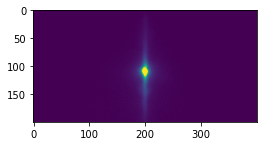

In [15]:
_, ax = plt.subplots(1, 1, figsize=(4, 8))
img.show(ctx=ax)


In [18]:
# def rle_encode(img)->str:
#     "Return run-length encoding string from `img`."
#     pixels = np.concatenate([[0], img.flatten() , [0]])
#     runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
#     runs[1::2] -= runs[::2]
#     return ' '.join(str(x) for x in runs)

# def rle_decode(mask_rle, shape):
#     "Return an image array from run-length encoded string `mask_rle` with `shape`."
#     s = mask_rle.split()
#     starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
#     starts -= 1
#     ends = starts + lengths
#     img = np.zeros(shape[0]*shape[1], dtype=np.uint)
#     for low, up in zip(starts, ends): img[low:up] = 1
#     return img.reshape(shape)

In [19]:
# def open_rle_from_df(fn, shape=None, cls=torch.Tensor):
#     row = df.loc[fn]
#     masks = []
#     for c in df.columns:
#         rle = row[c]
#         if isinstance(rle, str):
#             masks.append(rle_decode(rle, shape))
#         else:
#             masks.append(np.zeros(shape))
#     return cls(np.stack(masks, axis=0).astype(int))

In [20]:
# def open_rle_from_row(fn, shape=None, cls=torch.Tensor):
#     row = fn
#     masks = []
#     for c in row.index:
#         rle = row[c]
#         if isinstance(rle, str):
#             masks.append(rle_decode(rle, shape))
#         else:
#             masks.append(np.zeros(shape))
#     return cls(np.stack(masks, axis=0).astype(int))

In [21]:
# class RHEEDTensorMask(TensorMask):
#     def __init__(self, x, chnls_first=True):
#         self.chnls_first = chnls_first

#     @classmethod
#     def create(cls, data:(Path,str,ndarray,pd.Series), chnls_first=True, shape=None):
#         if isinstance(data, Path) or isinstance(data, str):
#             im = open_rle_from_df(fn=data, shape=shape, cls=torch.Tensor)
#         elif isinstance(data, pd.Series):
#             im = open_rle_from_row(fn=data, shape=shape, cls=torch.Tensor)
#         elif isinstance(data, ndarray): 
#             im = torch.from_numpy(data)
#         else:
#             im = data
            
#         return cls(im, chnls_first=chnls_first)

#     def show(self, chn=0, ctx=None):        
#         visu_mask = self[chn, ...]                
#         plt.imshow(visu_mask) if ctx is None else ctx.imshow(visu_mask)
#         return ctx
    
#     def __repr__(self):
        
#         return (f'RHEEDTensorMask: {self.shape}')

In [16]:
isinstance(df.index[0], str)

True

In [17]:
mask = RHEEDTensorMask.create(df.iloc[0], shape=(200,400))

In [18]:
print(mask.shape)

torch.Size([2, 200, 400])


<AxesSubplot:>

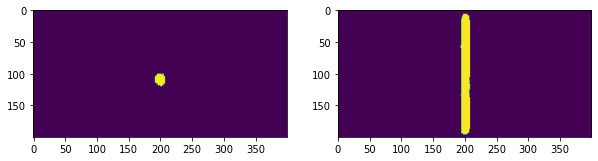

In [19]:
_, ax = plt.subplots(1, 2, figsize=(10, 5))
mask.show(chn=0, ctx=ax[0])
mask.show(chn=1, ctx=ax[1])

In [13]:
def get_lbl_fn(img_fn: Path):
    row = df.loc[img_fn]
    return row

def split_by_exp(val_exps):
    def _split_by_exp(x):
        if isinstance(x, Path) or isinstance(x, str):
            path = x
        elif isinstance(x, pd.Series):
            path = x.name 
        exp_code = path.split("/")[1]
        return exp_code in val_exps
            
    return _split_by_exp

val_exps = np.random.choice(exp_code, size=2, replace=False)
    
splitter = RandomSplitter(valid_pct=0.1) # valid on random sample
splitter = FuncSplitter(split_by_exp(val_exps))

In [21]:
val_exps

array(['IT004', 'IT017'], dtype=object)

In [22]:
df.index[:5]

Index(['/home/aurora/RHEED/2d3dprediction/IT003/IT003-700-_10.png',
       '/home/aurora/RHEED/2d3dprediction/IT003/IT003-700-_100.png',
       '/home/aurora/RHEED/2d3dprediction/IT003/IT003-700-_1000.png',
       '/home/aurora/RHEED/2d3dprediction/IT003/IT003-700-_1001.png',
       '/home/aurora/RHEED/2d3dprediction/IT003/IT003-700-_1002.png'],
      dtype='object', name='Image')

In [23]:
val_exps

array(['IT004', 'IT017'], dtype=object)

In [24]:
splitter(df.index[:5])

((#5) [0,1,2,3,4], (#0) [])

In [25]:
splitter([ f"2d3dprediction/{val_exps[0]}/001.png"])

((#0) [], (#1) [0])

In [14]:
# use the whole df as items
db = DataBlock(blocks=(TransformBlock(type_tfms=partial(RHEEDTensorImage.create, chnls_first=True)),
                       TransformBlock(type_tfms=partial(RHEEDTensorMask.create, chnls_first=True, shape=(200, 400)), 
                                      item_tfms=AddMaskCodes(codes=df.columns)),
                      ),
               get_items=lambda x: x,
               get_y = noop,
               get_x = noop,
               splitter=RandomSplitter(valid_pct=0.1)
              )

In [30]:
db.summary(source=df)

Setting-up type transforms pipelines
Image                                                                                                                                                                                                                                                                                               
/home/aurora/RHEED/2d3dprediction/IT003/IT003-700-_10.png                                        40197 6 40205 2 40596 11 40995 12 41395 12 41793 16 42193 16 42593 16 42993 16 43393 16 43793 16 44193 16 44593 16 44993 16 45393 16 45794 15 46195 14 46597 10 46997 10 47398 2 47401 5 47801 3   
/home/aurora/RHEED/2d3dprediction/IT003/IT003-700-_100.png                               39801 2 39805 1 40197 10 40596 11 40995 12 41394 14 41793 16 42193 16 42593 16 42993 16 43393 16 43793 16 44193 16 44593 16 44993 16 45394 15 45794 15 46195 13 46597 10 46997 9 47398 2 47401 2 47801 1   
/home/aurora/RHEED/2d3dprediction/IT003/IT003-700-_1000.png                         

2 datasets of sizes 11141,1237
Setting up Pipeline: partial
Setting up Pipeline: partial

Building one sample
  Pipeline: partial
    starting from
      Label
spot                                                                                                                                                                                                                                                                                                                  17748 2 18147 6 18547 6 18947 7 19347 8 19747 8 20147 8 20547 8 20949 4 21350 2 21798 7 22198 9 22595 13 22995 14 23394 16 23794 16 24175 2 24194 17 24574 4 24594 17 24973 6 24993 18 25374 5 25394 17 25777 1 25794 16 26194 16 26595 14 26995 14 27398 8 27800 5 41255 2 41653 5 42053 5 42453 5 42853 4
stripe    6602 3 7000 5 7328 4 7399 7 7727 5 7799 8 8127 6 8199 8 8527 6 8599 8 8926 7 8998 9 9326 8 9398 9 9725 9 9798 10 10125 9 10198 10 10525 10 10598 10 10925 10 10998 10 11325 10 11398 10 11725 10 11798 10 12125 10 12197 11 


Building one batch
Applying item_tfms to the first sample:
  Pipeline: AddMaskCodes -> ToTensor
    starting from
      (RHEEDTensorImage of size 3x200x400, RHEEDTensorMask of size 2x200x400)
    applying AddMaskCodes gives
      (RHEEDTensorImage of size 3x200x400, RHEEDTensorMask of size 2x200x400)
    applying ToTensor gives
      (RHEEDTensorImage of size 3x200x400, RHEEDTensorMask of size 2x200x400)

Adding the next 3 samples

No before_batch transform to apply

Collating items in a batch

No batch_tfms to apply


In [ ]:
# # use index as items
# db = DataBlock(blocks=(TransformBlock(type_tfms=partial(RHEEDTensorImage.create, chnls_first=True)),
#                        TransformBlock(type_tfms=partial(RHEEDTensorMask.create, chnls_first=True, shape=(200, 400)), 
#                                       item_tfms=AddMaskCodes(codes=df.columns)),
#                       ),
#                get_items=lambda x: L(df.index.tolist()),
#                get_y = noop,
#                get_x = lambda x: os.path.join(root, x),
#                splitter=RandomSplitter(valid_pct=0.1)
#               )

# db.summary(source=df)

In [15]:
ds = db.datasets(source=df)

<AxesSubplot:>

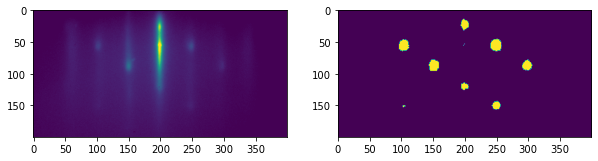

In [27]:
idx = 1
img = ds.train[idx][0]
msk = ds.train[idx][1]

_, ax = plt.subplots(1, 2, figsize=(10, 5))
img.show(ctx=ax[0])
msk.show(ctx=ax[1])

In [16]:
dls = ds.dataloaders(bs=4, num_workers=4)

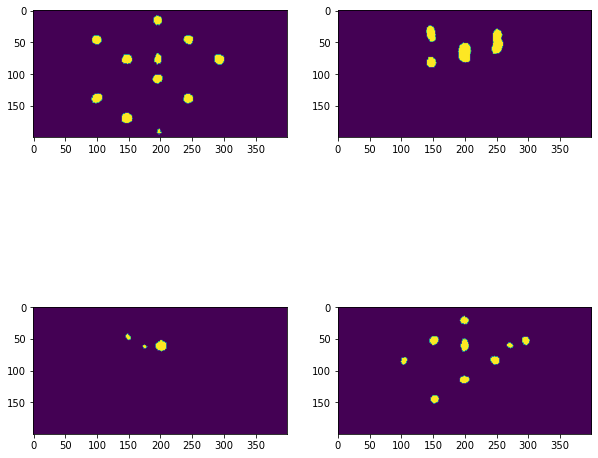

In [29]:
dls.show_batch(figsize=(10,10))

In [30]:
x, y = dls.one_batch()
type(x), type(y)

(rhana.labeler.unet.RHEEDTensorImage, rhana.labeler.unet.RHEEDTensorMask)

In [31]:
np.array(x.cpu()).max()

0.92941177

In [29]:
import pdb

In [32]:
# def bce_logits_floatify(input, target, reduction='mean'):
#     pdb.set_trace()
#     return F.binary_cross_entropy_with_logits(input, target.float(), reduction=reduction)

In [33]:
# # can use sigmoid on the input too, in this case the threshold would be 0.5
# def dice_metric(pred, targs, threshold=0.5):
#     pred = (pred > threshold).float()
#     targs = targs.float()  # make sure target is float too
#     return 2.0 * (pred*targs).sum() / ((pred+targs).sum() + 1.0)

In [17]:
learn = unet_learner(dls, resnet18, loss_func=BCEWithLogitsLossFlat(), n_out=len(df.columns), metrics=[dice_metric])

In [56]:
BCEWithLogitsLossFlat??

In [35]:
!nvidia-smi

Thu May  6 18:26:01 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.03   Driver Version: 450.119.03   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce GTX 1060    Off  | 00000000:01:00.0  On |                  N/A |
| N/A   51C    P0    29W /  N/A |   1376MiB /  6044MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [22]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,dice_metric,time
0,0.011413,0.009890,0.953535,16:17


epoch,train_loss,valid_loss,dice_metric,time
0,0.007516,0.007679,0.959763,16:54
1,0.007298,0.007256,0.965593,16:54
2,0.005788,0.006285,0.969050,16:54
3,0.005134,0.005653,0.973431,16:55
4,0.004755,0.005446,0.973821,16:55


In [166]:
ls ../

data/     notebook/  requirements.txt  rhana.egg-info/  tests/
learner/  README.md  rhana/            setup.py


In [23]:
learner_folder = Path("../learner")
learner_folder.mkdir(exist_ok=True)

In [24]:
learn.export(learner_folder/"UNet_May6_2021.pkl")

# Inference

## Inference with Single

In [25]:
learn = load_learner(learner_folder/"UNet_May6_2021.pkl")

In [26]:
additional = [
    "IT020",
    "IT021",
]

In [66]:
!ln -s /home/aurora/RHEED/data/RHEED/ ../data/raw

In [68]:
!ls ../data/raw

 after-depo   IT011   IT020-RHEED.zip   IT025		  IT030-RHEED.zip
 IT003	      IT012   IT021	        IT025-RHEED.zip   JPG
 IT004	      IT013   IT021-RHEED.zip   IT027		  maskIT005.pcd
 IT005	      IT014   IT022	        IT027-RHEED.zip   maskIT005.png
 IT006	      IT015   IT022-RHEED.zip   IT028		  mask.png
 IT007	      IT016   IT023	        IT028-RHEED.zip  'power point document'
 IT008	      IT017   IT023-RHEED.zip   IT029		  VI
 IT009	      IT018   IT024	        IT029-RHEED.zip
 IT010	      IT020   IT024-RHEED.zip   IT030


In [27]:
from rhana.pattern import Rheed

In [28]:
IT020 = Path("../data/raw/IT020") 
IT020_files = list(IT020.iterdir())

In [29]:
sample_file = IT020_files[0]

In [30]:
rd = Rheed.from_kashiwa(sample_file)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:>)

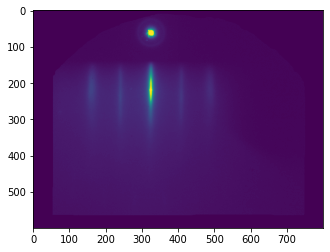

In [31]:
rd.plot_pattern()

In [32]:
proc_rd = rd.mean_clip(inplace=False).min_max_scale(inplace=False)

In [33]:
item = RHEEDTensorImage.create(np.tile(proc_rd.pattern, (3, 1, 1)))

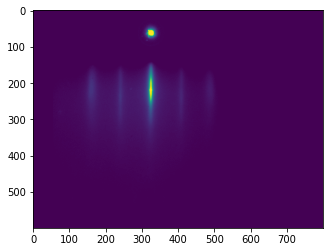

In [34]:
item.show()

In [35]:
result = learn.predict(item)

In [36]:
a,b,c = result

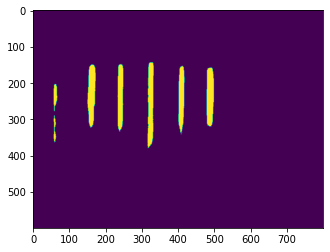

In [37]:
a.show(chn=1)

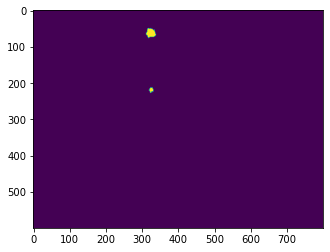

In [63]:
b.show()

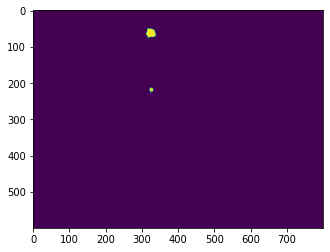

In [38]:
c.show()

## Inference with dataloader

In [ ]:
dls.test_dl() # add test dataloader